In [369]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [320]:
def GetTestPicture(numbero_uno):
    global myNormal, myPhoto, myVector, myAlbedo, myMask
    myNormal = np.load('BigData\TestBigPastelNormals.npy')[numbero_uno]
    myPhoto = np.load('BigData\TestBigPastelPhotos.npy')[numbero_uno]
    myVector = np.load('BigData\TestBigPastelVectors.npy')[numbero_uno]
    myAlbedo = np.load('BigData\TestBigPastelAlbedos.npy')[numbero_uno]
    myMask = np.load('BigData\TestBigPastelMasks.npy')[numbero_uno]

In [352]:
numbero_uno = 4
blurNormal = np.load('Sharpening/SharpenInputs/small_blurry_predictions.npy')[numbero_uno]
GetTestPicture(numbero_uno)
UpdateLightMap()

In [3]:
"""
def calculate_normal(points):
    v1 = points[1] - points[0]
    v2 = points[2] - points[0]
    normal = np.cross(v1, v2)
    return normal / np.linalg.norm(normal)
"""
def calculate_lighting(normal, light_direction):
    light_direction = light_direction / np.linalg.norm(light_direction)
    intensity = np.dot(normal, light_direction)
    return max(intensity, 0)  

In [4]:
def UpdateLightMap():
    global lightmap
    light_dir = myVector
    lightmap = np.zeros((64,64,3))
    for x in range(64):
      for y in range(64):
          one_normal = myNormal[x,y]
          intense = calculate_lighting(one_normal, light_dir)
          lightmap[x,y] = np.array([1,1,1]) * intense


<b>Формулы для плоского освещения</b> <p>
Работает не вполне корректно, так как освещается не объемный 3D объект, а всего лишь плоскость. Но в целом близко.
Нужно либо натренировать отдельную нейронку для освещения, либо же получить карту удаленности пикселя от камеры,
и соответственно его расположение в пространстве

In [324]:
ratio = 0.8
light_color = np.array([1,1,1])

In [321]:
light_direction_normalized = myVector / np.linalg.norm(myVector)
intensity = np.dot(myNormal, light_direction_normalized)
intensity = intensity - np.min(intensity)
intensity = intensity ** (1 / light_intensity)
intensity = np.stack([intensity, intensity, intensity], axis=2)
print(intensity.shape, np.max(intensity))
# Applying
newThing = myAlbedo * intensity * light_intensity
#newThing = newThing * ratio + intensity * (1 - ratio)
newThing = newThing * myMask

(64, 64, 3) 0.793036112040423


In [366]:
def light_up(my_normal, light_point, my_albedo, my_mask):
    light_direction_normalized = (light_point / np.linalg.norm(light_point))
    intensity = np.dot(my_normal, light_direction_normalized)
    intensity = np.clip(intensity, 0, 10)
    intensity = np.stack([intensity, intensity, intensity], axis=2)
    intensity = intensity #** 0.5
    intensity = intensity * light_color
    
    newThing = (my_albedo + intensity) * my_mask  # ** (1 / light_intensity)
    return newThing, intensity
# Помоему картинка не складывается потому что в normal map нету объема, 

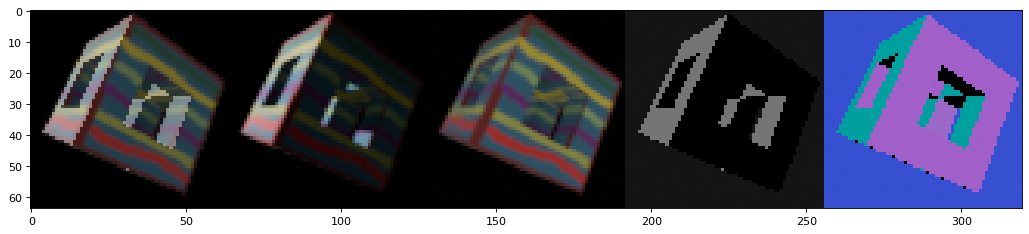

In [367]:
pictoshow, light_map = light_up(myNormal, myVector, myAlbedo, myMask)
plt.figure(figsize=(16, 12), dpi=80)
plt.imshow(np.concatenate([pictoshow, myPhoto, myAlbedo, light_map, myNormal], axis = 1))

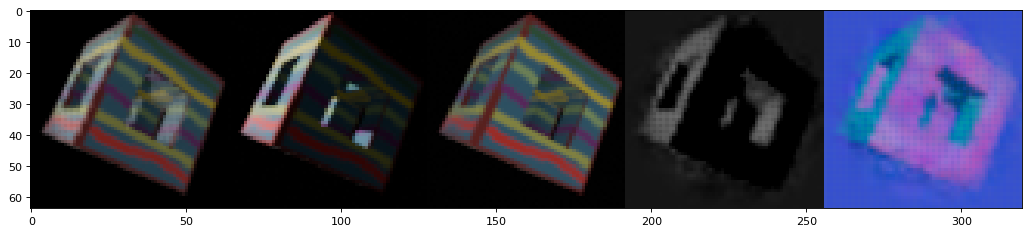

In [368]:
pictoshow, light_map = light_up(blurNormal, myVector, myAlbedo, myMask)
plt.figure(figsize=(16, 12), dpi=80)
plt.imshow(np.concatenate([pictoshow, myPhoto, myAlbedo, light_map, blurNormal], axis = 1))

<b>Вращение источника света и применение плоских нормалей

In [379]:
def rotate_vector(my_vector, degrees):
    x, y = my_vector
    pies = math.radians(degrees)
    new_x = x * math.cos(pies) - y * math.sin(pies)
    new_y = x * math.sin(pies) + y * math.cos(pies)
    return (round(new_x, 2),round(new_y, 2))

In [401]:
vector_list = np.zeros((24, 3))
for i in range(24):
    vector_to_add = myVector
    new_x, new_y = rotate_vector((vector_to_add[0], vector_to_add[1]), 15 * i)
    vector_list[i][0] = new_x
    vector_list[i][1] = new_y
    vector_list[i][2] = vector_to_add[2]

In [399]:
relit_albedos = np.zeros((24, 64,64,3))
for i in range(24):
    relit_albedos[i] = light_up(blurNormal, vector_list[i], myAlbedo, myMask)[0]
final_image = np.concatenate([
    np.concatenate(relit_albedos[0:6], axis = 1),
    np.concatenate(relit_albedos[6:12], axis = 1),
    np.concatenate(relit_albedos[12:18], axis = 1),
    np.concatenate(relit_albedos[18:24], axis = 1)   
    ], axis = 0 )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.092343520275791].


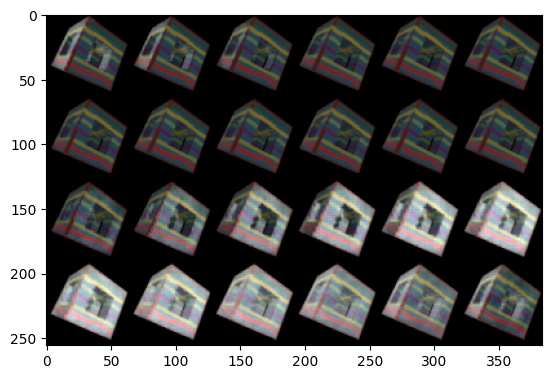

In [400]:
plt.imshow(final_image)

In [5]:
# Обратный процесс можно использовать чтобы получить из освещенного изображения диффузное изображение. 
# Это означает что: В целом нужна только модель нормалей
# Предсказав нормали я могу сначала убрать освещение с картинки, а затем добавить его используя один и тот же механизм
# В этой системе есть проблема: она считает что освещение точечное
# Картинки получены с учетом шарообразного источника света
# Поэтому даже тут они не совсем совпадают

In [6]:
#CONVINIENT TEST:

In [8]:
print(myVector)

[-0.354 -0.707  0.612]


[-0.354 -0.707  0.612]


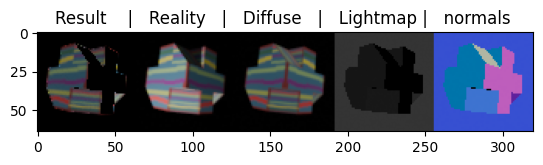

In [12]:
light_intensity = 4
ratio = 1
newThing = myAlbedo * lightmap * light_intensity
newThing = newThing  * ratio + lightmap * (1 - ratio)
newThing = (newThing / np.max( newThing)) * myMask
plt.title("Result    |   Reality   |   Diffuse   |   Lightmap |   normals ")
plt.imshow(np.concatenate([newThing, myPhoto, myAlbedo, lightmap, myNormal], axis = 1))
print(myVector)

C:\Users\Tomil\AppData\Local\Temp\ipykernel_12372\1147676661.py:4: RuntimeWarning: divide by zero encountered in divide
  zeroed = myPhoto / lightmap / light_intensity


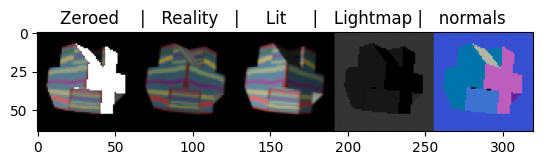

In [13]:
light_intensity = 10
ratio = 0.5

zeroed = myPhoto / lightmap / light_intensity
zeroed = zeroed * myMask
plt.title("Zeroed    |   Reality   |     Lit     |   Lightmap |   normals ")
plt.imshow(np.clip( np.concatenate([zeroed, myAlbedo, myPhoto, lightmap, myNormal], axis = 1), 0, 1))